In [6]:
import sys
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')
sys.path.append(pyAPES_main_folder)

from pyAPES.utils.iotools import read_forcing
from pyAPES.canopy.forestfloor import ForestFloor
from pyAPES.parameters.mlm_parameters import gpara, cpara, spara # model configuration, canopy parameters, soil parameters

import warnings
# Ignore FutureWarning messages globally
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [7]:
# Creating ForestFloor
forestfloor = ForestFloor(cpara['forestfloor'])

# Manipulating the params to correspond to those of Degerö
gpara['forc_filename'] = r'/Users/jpnousu/pyAPES_main/forcing/Degero/Degero_forcing_2014-2016.dat'
gpara['start_time'] = '2014-09-01'
gpara['end_time'] = '2015-06-01'

In [8]:
# Reading the forcing file
forcing = read_forcing(
    forcing_file=gpara['forc_filename'],
    start_time=gpara['start_time'],
    end_time=gpara['end_time'],
    dt=gpara['dt']
)

forcing['Prec_liquid'] = forcing['Prec'].where(forcing['Tair'] > 1, 0)
forcing['Prec_ice'] = forcing['Prec'].where(forcing['Tair'] <= 1, 0)
forcing['Tsoil'] = forcing['Tair'].rolling(window=480, min_periods=1, center=True).mean().clip(lower=-1)

In [9]:
# Looping over the forcing file, running forestfloor model for each timestep and saving the results
results_df = pd.DataFrame()

for index, row in forcing.iterrows():
    ff_forcing = {  # Reset the dictionary for each iteration
        'precipitation_rain': row['Prec_liquid'], # kg m-2 s-1
        'precipitation_snow': row['Prec_ice'], # kg m-2 s-1
        'wind_speed': row['U'], # m/s
        'par': row['diffPar'] + row['dirPar'],  # Total PAR [W m-2]
        'nir': row['diffNir'] + row['dirNir'],  # Total NIR [W m-2]
        'lw_dn': row['LWin'],  # Longwave downward radiation [W m-2]
        'h2o': row['H2O'] / 1000,  # H2O [mol mol-1]
        'co2': row['CO2'] * 1e6,  # Convert mol mol-1 to ppm
        'air_temperature': row['Tair'],  # Air temperature [degC]
        'air_pressure': row['P'],  # Air pressure [Pa]
        'soil_temperature': max(row['Tair']-2,0), # Soil temperature [degC]
        #'soil_temperature': row['Tsoil'], # Soil temperature [degC]
        'soil_water_potential': -10,
        'soil_volumetric_water': 0.3,
        'soil_volumetric_air': 0.3,
        'soil_pond_storage': 0
    }
    ff_params = {
        'soil_thermal_conductivity': 0.8,
        'soil_hydraulic_conductivity': 1e-5,
        'soil_depth': 0.02,
        'reference_height': 18.,
    }
    ff_controls = {
        'energy_balance': True,
        'logger_info': 'test',
    }
    # --- solve forestfloor
    ff_fluxes, ff_states, gt_results = forestfloor.run(
                dt=gpara['dt'],
                forcing=ff_forcing,
                parameters=ff_params,
                controls=ff_controls
                )
    
    forestfloor.update()
        
    # Combine results into a single dictionary with all values as floats
    combined_results = {
        'time': index,  # Use the time index from the forcing DataFrame
        **{f'gt_{key}': value[0] for key, value in gt_results.items()},  # Add gt_results
        **{f'ff_{key}': value for key, value in ff_states.items()},  # Add ff_results
        **{f'ff_{key}': value for key, value in ff_fluxes.items()},
    }

    # Append the combined results to the results DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([combined_results])], ignore_index=True)

results_df.set_index('time', inplace=True)

results_df['ff_snow_depth'] = results_df['ff_snow_depth'] * 100
#results_df['ff_srf_albedo'] = results_df['ff_srf_albedo'] * 100
results_df['Tsoil']=np.maximum(forcing['Tair']-2,0)

<Axes: xlabel='time'>

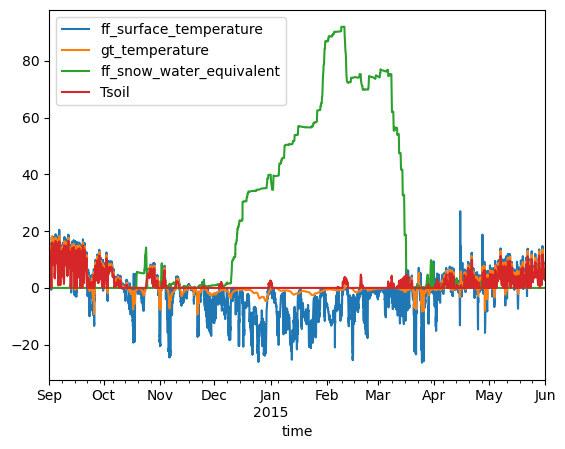

In [10]:
results_df[['ff_surface_temperature',
             'gt_temperature',
             'ff_snow_water_equivalent',
             #'ff_snow_depth',
             'Tsoil',
             #'gt_water_closure'
             #'ff_fsm_surface_temperature'
             ]].plot()

<Axes: xlabel='time'>

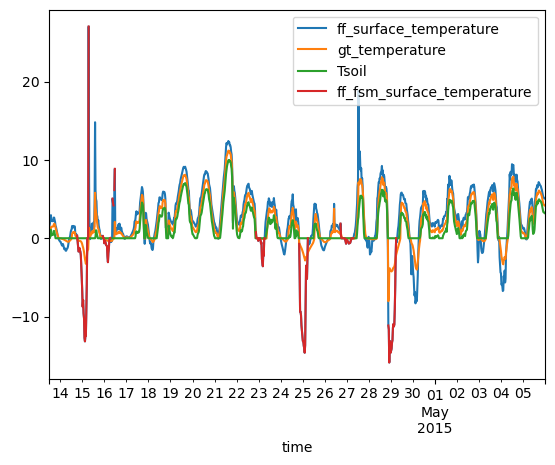

In [13]:
time_window = slice('2015-04-13 12:00', '2015-05-05')

results_df[time_window][['ff_surface_temperature', 
                                        'gt_temperature', 
                                        #'ff_snow_water_equivalent',
                                        #'ff_snow_depth',
                                        'Tsoil', 
                                        #'gt_water_closure',
                                        #'ff_srf_albedo',
                                        'ff_fsm_surface_temperature'
                                        ]].plot()

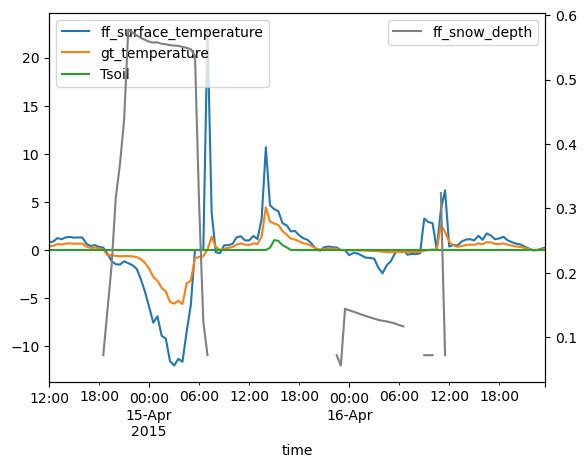

In [6]:
time_window = slice('2015-04-14 12:00', '2015-04-16')

fig, ax1 = plt.subplots()

# Primary y-axis plot
results_df[time_window][[
    'ff_surface_temperature', 
    'gt_temperature', 
    'Tsoil',
    #'ff_fsm_surface_temperature'
]].plot(ax=ax1)

# Secondary y-axis plot
ax2 = ax1.twinx()
results_df[time_window]['ff_snow_depth'].plot(ax=ax2, color='gray', label='ff_snow_depth')

# Add legends separately
ax1.legend(loc='upper left')

ax2.legend(loc='upper right')

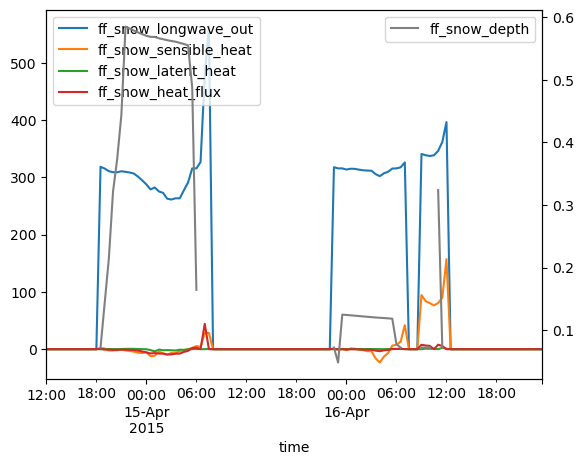

In [8]:
time_window = slice('2015-04-14 12:00', '2015-04-16')

fig, ax1 = plt.subplots()

# Primary y-axis plot
results_df[time_window][['ff_snow_longwave_out',
                                              'ff_snow_sensible_heat',
                                              'ff_snow_latent_heat',
                                              'ff_snow_heat_flux'
]].plot(ax=ax1)

# Secondary y-axis plot
ax2 = ax1.twinx()
results_df[time_window]['ff_snow_depth'].plot(ax=ax2, color='gray', label='ff_snow_depth')

# Add legends separately
ax1.legend(loc='upper left')

ax2.legend(loc='upper right')

In [14]:
forcing.columns

Index(['doy', 'Prec', 'P', 'Tair', 'Tdaily', 'U', 'Ustar', 'H2O', 'CO2', 'Zen',
       'LWin', 'diffPar', 'dirPar', 'diffNir', 'dirNir', 'X', 'DDsum',
       'Prec_liquid', 'Prec_ice', 'Tsoil'],
      dtype='object')

<Axes: >

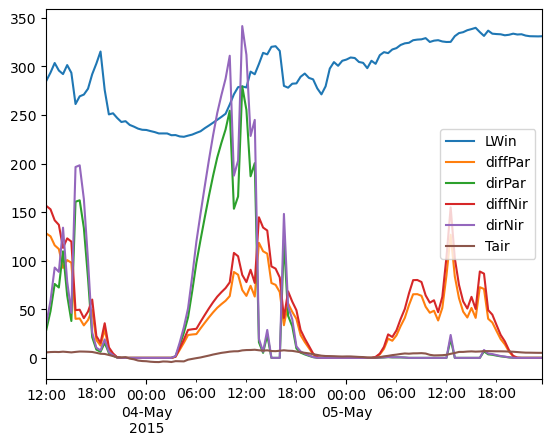

In [16]:
forcing['2015-05-03 12:00': '2015-05-05'][['LWin',
                                              'diffPar',
                                              'dirPar',
                                              'diffNir',
                                              'dirNir',
                                              'Tair'
                                        ]].plot()

In [16]:
results_df['2014-10-28': '2014-11-03'][['ff_snow_depth', 
                                        ]].plot()

KeyError: "None of [Index(['ff_snow_depth'], dtype='object')] are in the [columns]"

<Axes: xlabel='time'>

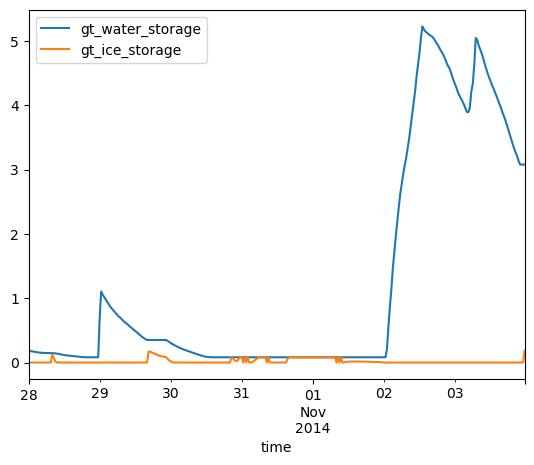

In [9]:
results_df['2014-10-28': '2014-11-03'][['gt_water_storage',
                                        'gt_ice_storage']].plot()

<Axes: xlabel='time'>

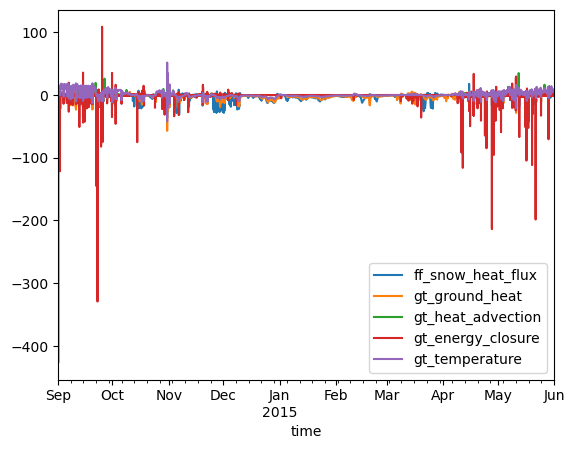

In [7]:
results_df[['ff_snow_heat_flux',
            'gt_ground_heat',
            'gt_heat_advection',
            'gt_energy_closure',
            'gt_temperature']].plot()